In [16]:
from torchvision import transforms
from PIL import Image
import os
import torch
from torch.utils.data import Dataset

class FrameDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        data = []
        folders = sorted(os.listdir(self.directory))
        for folder in folders:
            folder_path = os.path.join(self.directory, folder)
            if os.path.isdir(folder_path):
                frame1_path = os.path.join(folder_path, 'frame1.jpg')
                frame2_path = os.path.join(folder_path, 'frame2.jpg')
                frame3_path = os.path.join(folder_path, 'frame3.jpg')
                if os.path.exists(frame1_path) and os.path.exists(frame2_path) and os.path.exists(frame3_path):
                    data.append((frame1_path, frame2_path, frame3_path))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame1_path, frame2_path, frame3_path = self.data[idx]
        frame1 = Image.open(frame1_path).convert('RGB')
        frame2 = Image.open(frame2_path).convert('RGB')
        frame3 = Image.open(frame3_path).convert('RGB')

        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)

        return frame1, frame2, frame3


# Define the transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Use the dataset
dataset = FrameDataset("/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/datasets/train_10k", transform=image_transform)
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

class DiffusionModel(nn.Module):
    def __init__(self, input_channels=3):
        super(DiffusionModel, self).__init__()
        
        # Simple convolutional neural network for denoising
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, input_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.sigmoid(self.conv4(x))
        return x

def add_noise(image, noise_level=0.1):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    return noisy_image

def reverse_diffusion(noisy_image, model, num_steps=10):
    for _ in range(num_steps):
        noisy_image = model(noisy_image)
    return noisy_image

# Initialize the model and optimizer
model = DiffusionModel().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Loss function (Mean Squared Error)
criterion = nn.MSELoss()

# To track the loss and accuracy
train_losses = []


In [6]:
num_epochs = 50
noise_level = 0.1
num_steps = 10  # Reverse diffusion steps

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (frame1, frame2, frame3) in enumerate(dataloader):
        frame1, frame2, frame3 = frame1.cuda(), frame2.cuda(), frame3.cuda()

        # Add noise to frame2 (input)
        noisy_frame2 = add_noise(frame2, noise_level=noise_level)
        
        # Perform reverse diffusion to get the generated frame2
        generated_frame2 = reverse_diffusion(noisy_frame2, model, num_steps)

        # Compute loss (MSE between the generated frame2 and the ground truth frame3)
        loss = criterion(generated_frame2, frame3)
        epoch_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')


Epoch 1/50, Loss: 0.023277294648438692
Epoch 2/50, Loss: 0.014244693420082331
Epoch 3/50, Loss: 0.014013407994806767
Epoch 4/50, Loss: 0.013877999817579985
Epoch 5/50, Loss: 0.013818899211473763
Epoch 6/50, Loss: 0.013750940177589654
Epoch 7/50, Loss: 0.013659073040634394
Epoch 8/50, Loss: 0.01364613914899528
Epoch 9/50, Loss: 0.008817985022999346
Epoch 10/50, Loss: 0.0067634701611474154
Epoch 11/50, Loss: 0.006610472608543932
Epoch 12/50, Loss: 0.006514334744587541
Epoch 13/50, Loss: 0.006442293103784323
Epoch 14/50, Loss: 0.0064256607567891475
Epoch 15/50, Loss: 0.006418839145079255
Epoch 16/50, Loss: 0.006327402824722231
Epoch 17/50, Loss: 0.006389685576595366
Epoch 18/50, Loss: 0.006292057716660202
Epoch 19/50, Loss: 0.0062859635651111604
Epoch 20/50, Loss: 0.0062881497759372
Epoch 21/50, Loss: 0.006260641705989838
Epoch 22/50, Loss: 0.006289061781577766
Epoch 23/50, Loss: 0.0062037749459967016
Epoch 24/50, Loss: 0.00624510708078742
Epoch 25/50, Loss: 0.006248033144511282
Epoch 26/

In [17]:
    
def evaluate_model(test_dir, model):
    test_dataset = FrameDataset(test_dir,image_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    model.eval()
    mse_score = 0.0
    with torch.no_grad():
        for frame1, frame2, frame3 in test_dataloader:
            frame1, frame2, frame3 = frame1.cuda(), frame2.cuda(), frame3.cuda()

            # Add noise to frame2
            noisy_frame2 = add_noise(frame2, noise_level=noise_level)

            # Perform reverse diffusion
            generated_frame2 = reverse_diffusion(noisy_frame2, model, num_steps)

            # Calculate MSE score
            mse_score += criterion(generated_frame2, frame3).item()

    mse_score /= len(test_dataloader)
    print(f'MSE Score on Test Data: {mse_score}')
    return mse_score

# Example usage
test_dir = '/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/datasets/test_2k_original'
mse_score = evaluate_model(test_dir, model)


MSE Score on Test Data: 0.0058324247859418395


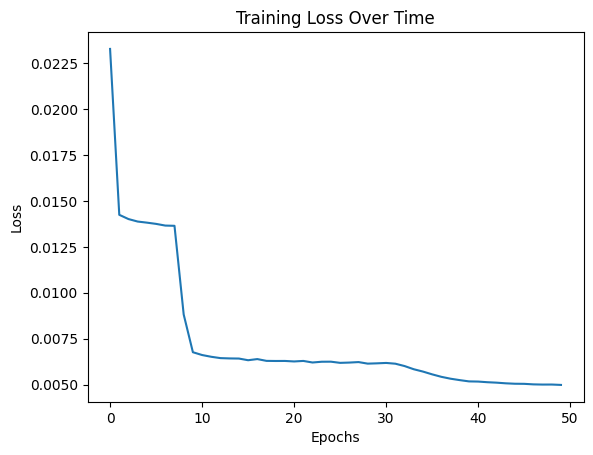

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()
